In [111]:
!pip install brian2

In [112]:
!pip install imageio[ffmpeg]

In [189]:
from keras.datasets import mnist
from brian2 import *
import brian2.numpy_ as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import euclidean_distances
import ssl
import requests
import imageio
import pandas as pd
from collections import Counter

defaultclock.dt = 0.022*us

'''
import brian2cuda
set_device("cuda_standalone")
'''

#Some code to fix SSL errors
requests.packages.urllib3.disable_warnings()

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

#Download the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [190]:
# Function to find indices of images with closest Euclidean distance for each digit class
#COMMENT THE BELOW CODE BLOCK IF YOU WANT AN UNBIASED DATASET
def find_closest_images(images, labels, num_closest=10):
    closest_indices = []
    for digit in range(10):
        digit_indices = np.where(labels == digit)[0]
        
        # Randomly choose an index from each digit class
        random_index = np.random.choice(digit_indices)
        closest_indices.append(random_index)

        # Calculate pairwise Euclidean distances
        distances = euclidean_distances(images[random_index].reshape(1, -1), images[digit_indices].reshape(len(digit_indices), -1))

        # Find indices of num_closest-1 images with smallest distances (excluding the randomly chosen one)
        closest_indices.extend(digit_indices[np.argsort(distances.flatten())[1:num_closest]])

    return closest_indices

# Find indices of closest images for each digit class
selected_indices = find_closest_images(X_train, y_train)

X_train = X_train[selected_indices]
y_train = y_train[selected_indices]

In [191]:
# Choose 1000 train images and 100 test images with all classes
num_train_per_class = 100
num_test_per_class = 1

# Initialize variables to store the selected indices
selected_train_indices = []
selected_test_indices = []

# Loop through each class
for class_label in range(10):  # MNIST has 10 classes (0 to 9)
    # Get indices of images with the current class label in the training set
    '''
    class_indices = np.where(y_train == class_label)[0]
    
    # Choose the first 'num_train_per_class' indices for training
    selected_train_indices.extend(class_indices[:num_train_per_class])
    '''

    # Get indices of images with the current class label in the test set
    class_indices = np.where(y_test == class_label)[0]
    
    # Choose the first 'num_test_per_class' indices for testing
    selected_test_indices.extend(class_indices[:num_test_per_class])

'''
# Select the corresponding images and labels for training and testing
X_train = X_train[selected_train_indices]
y_train = y_train[selected_train_indices]
'''

X_test = X_test[selected_test_indices]
y_test = y_test[selected_test_indices]

X_train = X_train/255.0
X_test = X_test/255.0


permutation_train = np.random.permutation(X_train.shape[0])
X_train = X_train[permutation_train]
y_train = y_train[permutation_train]

permutation_test = np.random.permutation(X_test.shape[0])
X_test = X_test[permutation_test]
y_test = y_test[permutation_test]


epoch = 1
n_input = 28*28 # input layer
n_output = 10 #output layer

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(100, 28, 28)
(100,)
(10, 28, 28)
(10,)


In [206]:
y_train[48] #35. 48

5

In [207]:
def encode_data(X):
    num_input = X.shape[1]*X.shape[2]
    #num_input = X.shape[1]
    num_timesteps_input = X.shape[0]
    num_timesteps_per_input = 1
    data = np.zeros((num_timesteps_input, num_input))
    for i in range(X.shape[0]):
        data[i*(num_timesteps_per_input):i*(num_timesteps_per_input) + num_timesteps_per_input, :] = X[i].ravel()
    return data

t_exposure = 110*us

data_training = encode_data(X_train)
data_eval_train = encode_data(X_train)
data_eval_test = encode_data(X_test)
#data_stim_in = np.zeros((n_output, n_input)) #Fix if using more than 1 neuron per digit
data_stim_in = np.zeros((4, n_input))

stimulus_list = []
for ep in range(epoch):
    stimulus_list.append(data_training)
    stimulus_list.append(data_eval_train)
    stimulus_list.append(data_eval_test)
    
'''  
X4 = X_train[12:13] #Randomly choose 1 sample to test retention
data_stim_retention = np.zeros((X4.shape[0], n_input))
data_stim_retention_noinput = np.zeros((X4.shape[0], n_input))
for i in range(X4.shape[0]):
    data_stim_retention[i:i+1, :] = X4[i].ravel()
'''


data_stim_retention_1 = np.zeros((1, n_input))
data_stim_retention_2 = np.zeros((1, n_input))
data_stim_retention_1[0, :] = X_train[35].ravel()
data_stim_retention_2[0, :] = X_train[48].ravel()
data_stim_retention_noinput = np.zeros((1, n_input))

    
stimulus_list.append(data_stim_retention_1)
stimulus_list.append(data_stim_retention_noinput)
stimulus_list.append(data_stim_retention_2)
stimulus_list.append(data_stim_retention_noinput)


stimulus_list.append(data_stim_in) #For recapitulation, no input

X3 = X_train[27:29] #Randomly choose some samples to test recapitulation + input feed
data_stim_inout = np.zeros((2*X3.shape[0], n_input))
for i in range(X3.shape[0]):
    data_stim_inout[2*i:2*i+1, :] = X3[i].ravel()
    data_stim_inout[2*i+1:2*i+2, :] = np.zeros((1, n_input)) #Just adding a gap, remove if needed
    
stimulus_list.append(data_stim_inout)

stimulus = TimedArray(np.vstack(stimulus_list), dt = t_exposure)

In [208]:
data_stim_inout.shape

(4, 784)

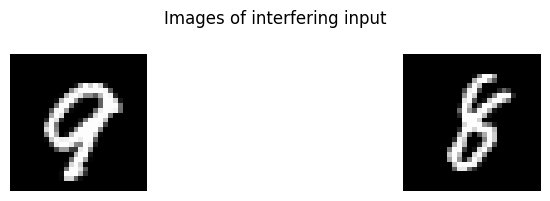

In [209]:
fig, axes = plt.subplots(1, 2, figsize=(10, 2))

for i, ax in enumerate(axes.flat):
    # Reshape the i-th row to 28x28
    image = X3[i, :].reshape(28, 28)

    # Plot the image
    ax.imshow(image, cmap='gray')
    ax.axis('off')  # Hide axis labels
#plt.savefig("image2.png")
plt.suptitle('Images of interfering input')
plt.tight_layout()
plt.show()

In [210]:
def encode_output_stimulus(X, y):
    num_input = n_output
    num_nodes_per_input = int(n_output/10)
    #num_input = X.shape[1]
    num_timesteps_input = X.shape[0]
    num_timesteps_per_input = 1
    data = np.zeros((num_timesteps_input, num_input))
    for i in range(X.shape[0]):
        data[i*(num_timesteps_per_input):i*(num_timesteps_per_input) + num_timesteps_per_input, :] = 1
        data[i*(num_timesteps_per_input):i*(num_timesteps_per_input) + num_timesteps_per_input, 
        num_nodes_per_input*y[i]:num_nodes_per_input*(y[i]+1)] = 0
    return data
#Net stimulus at output nodes = train_stim + back_stim

data_training = encode_output_stimulus(X_train, y_train)
data_eval_train = np.zeros((X_train.shape[0], n_output))
data_eval_test = np.zeros((X_test.shape[0], n_output))

#data_back_stim = np.array([[1 if j == i else 0 for j in range(n_output)] for i in range(n_output)]) #Fix this if using more than 1 neuron per class
data_back_stim_1 = np.array([[1 if j == i else 0 for j in range(n_output)] for i in range(1)]) 
data_back_stim_2 = np.zeros((1, n_output))
data_back_stim_3 = np.array([[1 if j == i else 0 for j in range(n_output)] for i in [1]]) 
data_back_stim_4 = np.zeros((1, n_output))
#data_stim_out = np.zeros((n_output, n_output))
data_stim_out = np.zeros((4, n_output))

data_stim_inout_1 =  np.array([[1 if j == i else 0 for j in range(n_output)] for i in range(1)])
data_stim_inout_2 = np.zeros((1, n_output))
data_stim_inout_3 = np.array([[1 if j == i else 0 for j in range(n_output)] for i in [1]])
data_stim_inout_4 = np.zeros((1, n_output))


stimulus_train_list = []
for ep in range(epoch):
    stimulus_train_list.append(data_training)
    stimulus_train_list.append(data_eval_train)
    stimulus_train_list.append(data_eval_test)
    
stimulus_train_list.append(np.zeros((4, n_output))) #Retention training stimulus at output nodes (0 array)

stimulus_train_list.append(data_stim_out) #Recapitulation training stimulus at output nodes (0 array)

#stimulus_train_list.append(np.zeros((X3.shape[0], n_output))) #Recap+INput training stimulus at output nodes (0 array)
stimulus_train_list.append(np.zeros((2*X3.shape[0], n_output))) #'' ''


    
stimulus_back_list = []
for ep in range(epoch):
    stimulus_back_list.append(np.zeros((X_train.shape[0], n_output)))
    stimulus_back_list.append(np.zeros((X_train.shape[0], n_output)))
    stimulus_back_list.append(np.zeros((X_test.shape[0], n_output)))
    
stimulus_back_list.append(np.zeros((4, n_output))) #Retention back stimulus at output nodes

stimulus_back_list.append(data_back_stim_1) #Recapitulation back stimulus at output nodes
stimulus_back_list.append(data_back_stim_2) #Recapitulation back stimulus at output nodes
stimulus_back_list.append(data_back_stim_3) #Recapitulation back stimulus at output nodes
stimulus_back_list.append(data_back_stim_4) #Recapitulation back stimulus at output nodes

#stimulus_back_list.append(data_stim_inout) #Recap+input back stimulus at output nodes
stimulus_back_list.append(data_stim_inout_1)
stimulus_back_list.append(data_stim_inout_2)
stimulus_back_list.append(data_stim_inout_3)
stimulus_back_list.append(data_stim_inout_4)


stimulus_train = TimedArray(np.vstack(stimulus_train_list), dt = t_exposure)
stimulus_back = TimedArray(np.vstack(stimulus_back_list), dt = t_exposure)

In [211]:
#np.savetxt('./tst.txt', data_training, fmt='%d')

In [212]:
I_max = 4*nA #Current term to convert input pixel intensities to current injections
I_inhibitory = 10*nA #Current unit term for the inhibitory connections among output neurons
I_b = -100*nA
I_back_stim = 10*nA


#LIF parameters as per Sahu et. al (2021)
gl = 30*nsiemens
el = -70*mV
C = 500e-15*farad

t_refractory = 5*us

# Neuron potenital parameters as per Sahu et. al (2021)
v_rest_in = -70.*mV #Resting membrane potential
v_reset_in = -70.*mV #Reset potential
v_thresh_in = 20.*mV #Threshold potential

v_rest_out = -70.*mV 
v_reset_out = -70.*mV
v_thresh_out = 20.*mV
vt0 = 20*mV
delta_v_thresh_out = 7.*mV #Homeostasis threshold
tauhomeo = 15*us 

#STDP related parameters as per Sahu et. al (2021)
tau1 = 10*us
tau2 = 20*us
mu = 1.7
gamma1 = 9.0
gamma2 = 15.0
w_stdp_max = 900.0
w_stdp_mean = 100
w_stdp_sd = 10

#Inhibitory synapse parameters as per Sahu et. al (2021)
#w_inhibitory_mean = -4000
#w_inhibitory_sd = 100
w_inhibitory_mean = -500
w_inhibitory_sd = 50


#Tempotron equation parameters as per Sahu et. al (2021)
tau_m = 10*us
tau_s = 2.5*us
I0 = 3e-12*amp
I02 = 1e-10*amp
I0_back = 9e-12*amp


# Implement the STDP rule from Sahu et. al (2021)
stdp='''
    w : 1
    lr : 1 (shared)
    '''     
on_pre='''
        lastspike_pre = t
        delta_t = (lastspike_pre - lastspike_post)
        w -= lr*gamma2*((w/w_stdp_max)**mu)*exp(-delta_t/tau2)
        x_lt1_lt2_post += I0*w
        '''
on_post='''
        lastspike_post = t
        delta_t = (lastspike_post - lastspike_pre)
        w += lr*gamma1*((1-w/w_stdp_max)**mu)*exp(-delta_t/tau1)
        '''



class Model():
    
    def __init__(self, debug=False):
        
        app = {}
        #Sensory group
        neuron_sensory = '''
        dv/dt = (-gl*(v-el)+ stimulus(t, i)*I_max)/C : volt
        '''
        
        #Working memory
        neuron_working = '''
        dv/dt = (-gl*(v-el)+ I_sensory_working + I_lt1_working)/C : volt
        dI_sensory_working/dt =  ((tau_m / tau_s-1)*x_sensory_working-I_sensory_working)/tau_m : amp
        dx_sensory_working/dt = -x_sensory_working/tau_s : amp
        dI_lt1_working/dt =  ((tau_m / tau_s-1)*x_lt1_working-I_lt1_working)/tau_m : amp
        dx_lt1_working/dt = -x_lt1_working/tau_s : amp
        '''
               
        # Input group (lt1)
        neuron_input = '''
        dv/dt = (-gl*(v-el) + I_lt2_lt1 + I_working_lt1)/C : volt
        dI_working_lt1/dt =  ((tau_m / tau_s-1)*x_working_lt1-I_working_lt1)/tau_m : amp
        dx_working_lt1/dt = -x_working_lt1/tau_s : amp
        dI_lt2_lt1/dt =  ((tau_m / tau_s-1)*x_lt2_lt1-I_lt2_lt1)/tau_m : amp
        dx_lt2_lt1/dt = -x_lt2_lt1/tau_s : amp
        '''
        
        app['SensoryGroup'] = NeuronGroup(n_input, neuron_sensory, threshold='v>v_thresh_in', refractory=t_refractory,
                                        reset='v=v_reset_in', method='euler', name='SensoryGroup')
        app['SensoryGroup'].v = v_rest_in
        
        app['SensoryGroup'].run_regularly("v = v_rest_in", dt = t_exposure)
        
        
        app['WorkingGroup'] = NeuronGroup(n_input, neuron_working, threshold='v>v_thresh_in', refractory=t_refractory,
                                        reset='v=v_reset_in', method='euler', name='WorkingGroup')
        app['WorkingGroup'].v = v_rest_in
        
        #app['WorkingGroup'].run_regularly("v = v_rest_in; I_sensory_working = 0*amp; I_lt1_working = 0*amp", dt = t_exposure) 
        app['WorkingGroup'].run_regularly("v = v_rest_in", dt = t_exposure) #Just for testing the retention, REPLACE!!
        
        
        app['InputGroup'] = NeuronGroup(n_input, neuron_input, threshold='v>v_thresh_in', refractory=t_refractory,
                                        reset='v=v_reset_in', method='euler', name='InputGroup')
        app['InputGroup'].v = v_rest_in
        
        app['InputGroup'].run_regularly("v = v_rest_in; I_working_lt1 = 0*amp; I_lt2_lt1 = 0*amp", dt = t_exposure)
        
        if (debug):
            app['SSP'] = SpikeMonitor(app['SensoryGroup'], name='SSP')
            app['WSP'] = SpikeMonitor(app['WorkingGroup'], name='WSP')
            app['ISP'] = SpikeMonitor(app['InputGroup'], name='ISP')
            app['ISM'] = StateMonitor(app['InputGroup'], ['v'], record=True, name='ISM')
            app['IRM'] = PopulationRateMonitor(app['InputGroup'], name='IRM')
        
        
        #Output group (lt2)
        neuron_output = '''
            dv/dt = (-gl*(v-el) + I_lt1_lt2 + stimulus_train(t, i)*I_b + stimulus_back(t, i)*I_back_stim)/C : volt
            dvt/dt = (vt0-vt)/tauhomeo : volt
            dI_lt1_lt2/dt = ((tau_m / tau_s-1)*x_lt1_lt2-I_lt1_lt2)/tau_m : amp
            dx_lt1_lt2/dt = -x_lt1_lt2/tau_s                      : amp
            '''
        neuron_output_reset = '''
                            v = v_reset_out
                            vt += delta_v_thresh_out
                            '''
        app['OutputGroup'] = NeuronGroup(n_output, neuron_output, threshold='v>vt', refractory=5*us,
                                        namespace={'C': C, 'gl': gl, 'el': el, 'tauhomeo':tauhomeo},
                                        reset=neuron_output_reset, method='euler', name='OutputGroup')
        app['OutputGroup'].v = v_rest_out
        app['OutputGroup'].vt = vt0
        
        app['OutputGroup'].run_regularly("v = v_rest_out; I_lt1_lt2 = 0*amp; vt = vt0; x_lt1_lt2 = 0*amp", dt = t_exposure)


        if (debug):
            app['OSP'] = SpikeMonitor(app['OutputGroup'], name='OSP')
            #app['OSM'] = StateMonitor(app['OutputGroup'], ['v', 'I', 'x', 'vt'], record=True, name='OSM')
            app['ORM'] = PopulationRateMonitor(app['OutputGroup'], name='ORM')
        
        # one-to all STDP connections between input and output  
        app['S1'] = Synapses(app['InputGroup'], app['OutputGroup'], stdp, on_pre=on_pre, on_post=on_post, method='euler', name='S1')
        app['S1'].connect()
        app['S1'].w = 'randn()*w_stdp_sd + w_stdp_mean' # random weights initialisation
        app['S1'].lr = 1 # enable stdp        
        
        if (debug):
            # some synapses
            app['S1M'] = StateMonitor(app['S1'], ['w'], record=app['S1'][294,:4], name='S1M') 
        
        # Output neurons one-to-all-except-one connections (inhibitory)
        app['S2'] = Synapses(app['OutputGroup'], app['OutputGroup'], 'w : 1', on_pre='I_lt1_lt2_post += w*I_inhibitory', name='S2')
        app['S2'].connect(condition='i!=j')
        #app['S2'].delay = 'rand()*0.5*us'
        app['S2'].w = 'randn()*w_inhibitory_sd + w_inhibitory_mean' # weights are selected in such a way as to maintain a balance between excitation and ibhibition
        
        #Synapses from output to input neurons for recapitulation
        app['S3'] = Synapses(app['InputGroup'], app['OutputGroup'], 'w2 : 1', on_post='x_lt2_lt1_pre += I0_back*w2', method='euler', name='S3')
        app['S3'].connect()
        app['S3'].w2 = 0
        
        #Synapses from sensory to working (one to one)
        app['S4'] = Synapses(app['SensoryGroup'], app['WorkingGroup'], 'w : 1', on_pre='x_sensory_working_post += I02*w', method='euler', name='S4')
        app['S4'].connect(condition = 'i==j')
        app['S4'].w = 120
        
        #Synapses from working to input (lt1) (one to one)
        app['S5'] = Synapses(app['WorkingGroup'], app['InputGroup'], 'w : 1', on_pre='x_working_lt1_post += I02*w', method='euler', name='S5')
        app['S5'].connect(condition = 'i==j')
        app['S5'].w = 120
        
        #Synapses from input (lt1) to working (one to one)
        app['S6'] = Synapses(app['WorkingGroup'], app['InputGroup'], 'w3 : 1', on_post='x_lt1_working_pre += I02*w3', method='euler', name='S6')
        app['S6'].connect(condition = 'i==j')
        app['S6'].w3 = 0
        
        
        self.net = Network(app.values())
        self.net.run(0*second)
        
        
    def __getitem__(self, key):
        return self.net[key]
    
    def train(self, X_train, y_train, X_test, y_test, epoch=1):        
        self.net['S1'].lr = 1 # stdp on
        hstat_sw = 1
        
        #TO DO: Add the epoch loop, think very carefully about how simulation times will play out
        time_elapsed = 0
        train_acc_list = []
        test_acc_list = []
        for ep in range(epoch):
            #self.net['OutputGroup'].vt = vt0
            self.net.run((t_exposure)*X_train.shape[0], report = 'text', report_period = 30*second)
            time_elapsed += (t_exposure)*X_train.shape[0] 
            print('Starting the evalutation process!')
            #self.net['OutputGroup'].vt = vt0
            train_accuracy, time = self.evaluate_v2(X_train, y_train, time_elapsed)
            time_elapsed += time
            print('Train Accuracy after epoch {}: {}%'.format(ep+1, train_accuracy))
            train_acc_list.append(train_accuracy)
            #self.net['OutputGroup'].vt = vt0
            test_accuracy, time = self.evaluate_v2(X_test, y_test, time_elapsed)
            time_elapsed += time
            print('Test Accuracy after epoch {}: {}%'.format(ep+1, test_accuracy))
            test_acc_list.append(test_accuracy)
            self.net['S1'].lr = 1 #Switch on STDP after evaluating
        return train_acc_list, test_acc_list, time_elapsed, np.array(self.net['S1'].w)

    def assign_output_labels(self, features, labels):
        num_neurons = features[0].shape[0]
        result_dict = {}

        for neuron_idx in range(num_neurons):
            neuron_spikes_by_label = Counter()

            for sample_idx, feature_vector in enumerate(features):
                spikes = feature_vector[neuron_idx]
                label = labels[sample_idx]
                neuron_spikes_by_label[label] += np.sum(spikes)

            # Find the label with the maximum spikes for this neuron
            max_label, _ = neuron_spikes_by_label.most_common(1)[0]
            result_dict[neuron_idx] = max_label

        return result_dict

    def evaluate_v2(self, X, y, time_elapsed):   
        self.net['S1'].lr = 0 
        features = []
        
        mon = SpikeMonitor(self.net['OutputGroup'], name='OutputRateMonitor')
        self.net.add(mon)
        duration = (t_exposure)*X.shape[0]
        self.net.run(duration, report = 'text', report_period = 30*second)

        interval_duration = (t_exposure)
        num_intervals = int(duration / interval_duration)
        #print(mon.spike_trains())
        #plot(mon.t/us, mon.i, '.b', label = 'out')
        for interval in range(num_intervals):
            base_time = time_elapsed 
            interval_start = base_time + interval * interval_duration
            interval_end = base_time + (interval + 1) * interval_duration
          
            # Extract spikes within the interval for each neuron
            spikes_in_interval = {neuron: spike_times[(spike_times >= interval_start) & (spike_times < interval_end)]
                          for neuron, spike_times in mon.spike_trains().items()}
            # Get spike counts for each neuron
            spike_counts = np.array([len(spike_times) for spike_times in spikes_in_interval.values()])
            # Append the spike counts for the current interval to the list
            features.append(spike_counts)

        self.net.remove(self.net['OutputRateMonitor'])
        
        num_correct = 0
        num_total = len(features)
        for i, spike_array in enumerate(features):
            neuron_idx = np.argmax(spike_array)
            if (neuron_idx >= y[i]*(n_output/10) and neuron_idx < (y[i]+1)*(n_output/10)):
                num_correct += 1
        return (num_correct/num_total)*100.0, duration
    
    def recapitulate(self, time_elapsed):
        #Note this does not work for more than 1 neuron per class; TO DO
        features = []
        features_video = []
        print('Starting Recapitulation!')
        w_s1 = np.array(self.net['S1'].w)
        #w_s1 = best_weight
        w_s2  = np.array(self.net['S2'].w)
        w_s4 = np.array(self.net['S4'].w)
        w_s5 = np.array(self.net['S5'].w)
        self.net['S1'].w = 0
        self.net['S1'].lr = 0
        self.net['S2'].w = 0
        self.net['S4'].w = 0
        self.net['S5'].w = 0
        self.net['S3'].w2 = w_s1
        self.net['S6'].w3 = 400
        features = []
        
        mon = SpikeMonitor(self.net['WorkingGroup'], name='WorkingRateMonitor')
        self.net.add(mon)
        duration = (t_exposure)*4
        self.net.run(duration, report = 'text', report_period = 30*second)

        interval_duration = (t_exposure)
        interval_duration_video = (t_exposure)/110
        num_intervals = int(duration / interval_duration)
        num_intervals_video = int(duration / interval_duration_video)
        
        for interval in range(num_intervals):
            base_time = time_elapsed 
            interval_start = base_time + interval * interval_duration
            interval_end = base_time + (interval + 1) * interval_duration
          
            # Extract spikes within the interval for each neuron
            spikes_in_interval = {neuron: spike_times[(spike_times >= interval_start) & (spike_times < interval_end)]
                          for neuron, spike_times in mon.spike_trains().items()}
            # Get spike counts for each neuron
            spike_counts = np.array([len(spike_times) for spike_times in spikes_in_interval.values()])
            # Append the spike counts for the current interval to the list
            features.append(spike_counts)
            
        for interval in range(num_intervals_video):
            base_time = time_elapsed 
            interval_start = base_time + interval * interval_duration_video
            interval_end = base_time + (interval + 1) * interval_duration_video
          
            # Extract spikes within the interval for each neuron
            spikes_in_interval = {neuron: spike_times[(spike_times >= interval_start) & (spike_times < interval_end)]
                          for neuron, spike_times in mon.spike_trains().items()}
            # Get spike counts for each neuron
            spike_counts = np.array([len(spike_times) for spike_times in spikes_in_interval.values()])
            # Append the spike counts for the current interval to the list
            features_video.append(spike_counts)

        self.net.remove(self.net['WorkingRateMonitor'])
        self.net['S1'].w = w_s1
        self.net['S1'].lr = 1
        self.net['S2'].w = w_s2
        self.net['S3'].w2 = 0
        self.net['S4'].w = w_s4
        self.net['S5'].w = w_s5
        self.net['S6'].w3 = 0
        
        return features, features_video, time_elapsed + duration
    
    def recap_input(self, time_elapsed):
        #Note this does not work for more than 1 neuron per class; TO DO
        features = []
        print('Starting Recapitulation + Input Feeding!')
        w_s1 = np.array(self.net['S1'].w)
        w_s2  = np.array(self.net['S2'].w)
        w_s4 = np.array(self.net['S4'].w)
        w_s5 = np.array(self.net['S5'].w)
        self.net['S1'].w = 0
        self.net['S1'].lr = 0
        self.net['S2'].w = 0
        self.net['S4'].w = 400
        self.net['S5'].w = 0
        self.net['S3'].w2 = w_s1
        self.net['S6'].w3 = 400
        features = []
        features_video = []
        
        mon = SpikeMonitor(self.net['WorkingGroup'], name='WorkingRateMonitor')
        self.net.add(mon)
        duration = (t_exposure)*5
        self.net.run(duration, report = 'text', report_period = 30*second)

        interval_duration = (t_exposure)
        interval_duration_video = t_exposure/110
        num_intervals = int(duration / interval_duration)
        num_intervals_video = int(duration / interval_duration_video)
        
        for interval in range(num_intervals):
            base_time = time_elapsed 
            interval_start = base_time + interval * interval_duration
            interval_end = base_time + (interval + 1) * interval_duration
          
            # Extract spikes within the interval for each neuron
            spikes_in_interval = {neuron: spike_times[(spike_times >= interval_start) & (spike_times < interval_end)]
                          for neuron, spike_times in mon.spike_trains().items()}
            # Get spike counts for each neuron
            spike_counts = np.array([len(spike_times) for spike_times in spikes_in_interval.values()])
            # Append the spike counts for the current interval to the list
            features.append(spike_counts)
        
        for interval in range(num_intervals_video):
            base_time = time_elapsed 
            interval_start = base_time + interval * interval_duration_video
            interval_end = base_time + (interval + 1) * interval_duration_video
          
            # Extract spikes within the interval for each neuron
            spikes_in_interval = {neuron: spike_times[(spike_times >= interval_start) & (spike_times < interval_end)]
                          for neuron, spike_times in mon.spike_trains().items()}
            # Get spike counts for each neuron
            spike_counts = np.array([len(spike_times) for spike_times in spikes_in_interval.values()])
            # Append the spike counts for the current interval to the list
            features_video.append(spike_counts)

        self.net.remove(self.net['WorkingRateMonitor'])
        self.net['S1'].w = w_s1
        self.net['S1'].lr = 1
        self.net['S2'].w = w_s2
        self.net['S3'].w2 = 0
        self.net['S4'].w = w_s4
        self.net['S5'].w = w_s5
        self.net['S6'].w3 = 0
        
        return features, features_video, time_elapsed + duration
    
    def retention(self, time_elapsed):
        #Note this does not work for more than 1 neuron per class; TO DO
        features = []
        features_video = []
        print('Starting Test of Retention!')
        self.net['S1'].lr = 0
        self.net['S4'].w = 600
        
        mon = SpikeMonitor(self.net['WorkingGroup'], name='WorkingRateMonitor')
        self.net.add(mon)
        duration = (t_exposure)*4
        self.net.run(duration, report = 'text', report_period = 30*second)

        interval_duration = (t_exposure)
        interval_duration_video = (t_exposure)/110
        num_intervals = int(duration / interval_duration)
        num_intervals_video = int(duration / interval_duration_video)

        for interval in range(num_intervals):
            base_time = time_elapsed
            interval_start = base_time + interval * interval_duration
            interval_end = base_time + (interval + 1) * interval_duration
            # Extract spikes within the interval for each neuron
            spikes_in_interval = {neuron: spike_times[(spike_times >= interval_start) & (spike_times < interval_end)]
                          for neuron, spike_times in mon.spike_trains().items()}
            # Get spike counts for each neuron
            spike_counts = np.array([len(spike_times) for spike_times in spikes_in_interval.values()])
            # Append the spike counts for the current interval to the list
            features.append(spike_counts)
            
        for interval in range(num_intervals_video):
            base_time = time_elapsed
            interval_start = base_time + interval * interval_duration_video
            interval_end = base_time + (interval + 1) * interval_duration_video
            # Extract spikes within the interval for each neuron
            spikes_in_interval = {neuron: spike_times[(spike_times >= interval_start) & (spike_times < interval_end)]
                          for neuron, spike_times in mon.spike_trains().items()}
            # Get spike counts for each neuron
            spike_counts = np.array([len(spike_times) for spike_times in spikes_in_interval.values()])
            # Append the spike counts for the current interval to the list
            features_video.append(spike_counts)

        self.net.remove(self.net['WorkingRateMonitor'])
        self.net['S1'].lr = 1
        self.net['S4'].w = 120
        
        return features, features_video, time_elapsed + duration
            

In [213]:
def supervised_learning(X_train, y_train, X_test, y_test):   
    seed(69420)
    
    model = Model(debug = False)
    train_acc_list, test_acc_list, time, best_weight_2 = model.train(X_train, y_train, X_test, y_test, epoch=epoch)
    #model.net.store('train', 'train.b2')
    #model.net.restore('train', './train.b2')
    spikes = {}
    video_features = {}
    retention_spikes, retention_video_features, time = model.retention(time)
    back_spikes, recap_video_features, time = model.recapitulate(time)
    inout_spikes, recap_input_video_features, time = model.recap_input(time)
    spikes['Retention'] = retention_spikes
    spikes['Recap'] = back_spikes
    spikes['RecapInput'] = inout_spikes
    video_features['Retention'] = retention_video_features
    video_features['Recap'] = recap_video_features
    video_features['RecapInput'] = recap_input_video_features
    
    return model, train_acc_list, test_acc_list, spikes, video_features, best_weight_2



    
model, train_acc_list, test_acc_list, spikes, video_features, best_weight_2 = supervised_learning(X_train, y_train, X_test, y_test)

retention_spikes = spikes['Retention']
back_spikes = spikes['Recap']
inout_spikes = spikes['RecapInput']

retention_video_features = video_features['Retention']
recap_video_features = video_features['Recap']
recap_input_video_features = video_features['RecapInput']

epoch_list = np.arange(1, epoch+1)

acc_data = {
    'Epoch': epoch_list,
    'Train_Accuracy': train_acc_list,
    'Test_Accuracy': test_acc_list
}

df = pd.DataFrame(acc_data)
#df.to_csv('./results/snnmnist-supervised.csv', index=False)

Starting simulation at t=0. s for a duration of 11. ms
3.087634 ms (28%) simulated in 30s, estimated 1m 17s remaining.
6.009784 ms (54%) simulated in 1m 0s, estimated 50s remaining.
8.797426 ms (79%) simulated in 1m 30s, estimated 23s remaining.
11. ms (100%) simulated in 1m 53s
Starting the evalutation process!
Starting simulation at t=11. ms for a duration of 11. ms
2.663584 ms (24%) simulated in 30s, estimated 1m 34s remaining.
5.342326 ms (48%) simulated in 1m 0s, estimated 1m 4s remaining.
7.941824 ms (72%) simulated in 1m 30s, estimated 35s remaining.
10.606464 ms (96%) simulated in 2m 0s, estimated 4s remaining.
11. ms (100%) simulated in 2m 4s
Train Accuracy after epoch 1: 66.0%
Starting simulation at t=22. ms for a duration of 1.1 ms
1.1 ms (100%) simulated in 12s
Test Accuracy after epoch 1: 10.0%
Starting Test of Retention!
Starting simulation at t=23.1 ms for a duration of 0.44 ms
0.44 ms (100%) simulated in 4s
Starting Recapitulation!
Starting simulation at t=23.54 ms for 

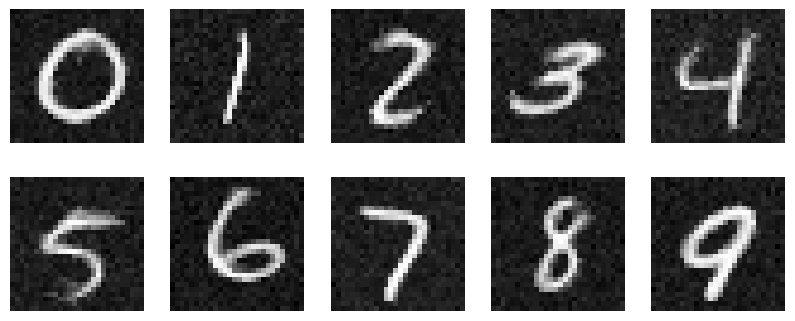

In [214]:
weights = np.array(model['S1'].w)/w_stdp_max
weights = weights.reshape(784, n_output)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    # Reshape the i-th row to 28x28
    image = weights.T[i, :].reshape(28, 28)

    # Plot the image
    ax.imshow(image, cmap='gray')
    ax.axis('off')  # Hide axis labels

plt.show()

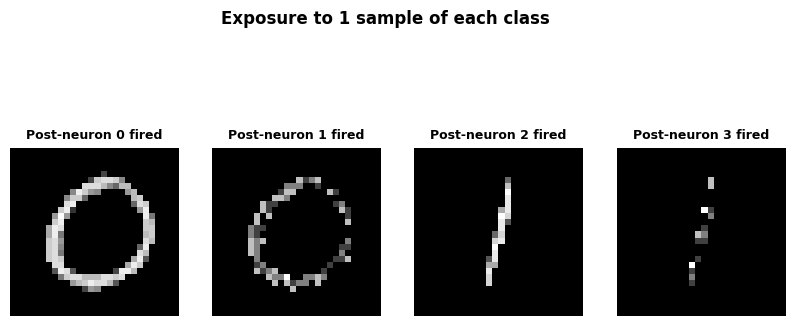

In [215]:
back_spikes = np.array(back_spikes)

#fig, axes = plt.subplots(2, 5, figsize=(10, 4))
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    # Reshape the i-th row to 28x28
    image = back_spikes[i, :].reshape(28, 28)

    # Plot the image
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Post-neuron {i} fired", fontsize=9, fontweight = 'bold',)
    ax.axis('off')  # Hide axis labels
fig.suptitle("Exposure to 1 sample of each class", fontsize=12, fontweight = 'bold', y=1.05)
plt.savefig("image.png")
plt.show()

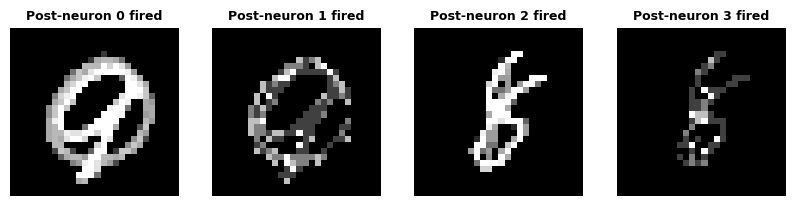

In [216]:
inout_spikes = np.array(inout_spikes)

fig, axes = plt.subplots(1, 4, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    # Reshape the i-th row to 28x28
    image = inout_spikes[i, :].reshape(28, 28)

    # Plot the image
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Post-neuron {i} fired", fontsize=9, fontweight = 'bold',)
    ax.axis('off')  # Hide axis labels
#plt.savefig("image2.png")
plt.show()

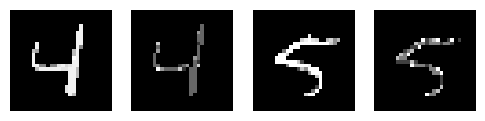

In [217]:
retention_spikes = np.array(retention_spikes)

fig, axes = plt.subplots(1, 4, figsize=(6, 4))

for i, ax in enumerate(axes.flat):
    # Reshape the i-th row to 28x28
    image = retention_spikes[i, :].reshape(28, 28)

    # Plot the image
    ax.imshow(image, cmap='gray')
    #ax.set_title(f"t={i*110}us after stimulus \n end", fontsize=9, fontweight = 'bold',)
    ax.axis('off')  # Hide axis labels
#plt.savefig("image2.png")
plt.show()

In [218]:
def create_video_2(features_video):
    features_video = (np.array(features_video) > 0).astype(int)
    reshaped_frames = features_video.reshape(-1, 28, 28)
    #reshaped_frames = reshaped_frames[:150, :, :]
    # Create a list to store the images
    images = []

    # Convert frames to uint8
    for frame in reshaped_frames:
        # Scale the pixel values to 0-255 for display purposes (assuming the binary array is 0 or 1)
        frame_display = (frame * 255).astype(np.uint8)

        # Repeat the frame along the third axis to make it a grayscale image
        frame_display = np.repeat(frame_display[:, :, np.newaxis], 3, axis=2)
        images.append(frame_display)

    # Save the images as an AVI file using MJPG codec
    writer = imageio.get_writer('output_video.avi', fps=10, codec='mjpeg')
    for image in images:
        writer.append_data(image)
    writer.close()

    print("Video created successfully.")

#create_video_2(retention_video_features)
create_video_2(retention_video_features)
    

Video created successfully.


Incompatible pixel format 'yuv420p' for codec 'mjpeg', auto-selecting format 'yuvj420p'
[swscaler @ 0x678c400] deprecated pixel format used, make sure you did set range correctly
[swscaler @ 0x678c400] Warning: data is not aligned! This can lead to a speed loss


In [129]:
def plot_w(S1M):
    plt.rcParams["figure.figsize"] = (20,10)
    plot(S1M.t/us, S1M.w.T/w_stdp_max)
    ylabel('w / wmax')
    show();
    
def plot_v(OSM, ISM, neuron=0):
    plt.rcParams["figure.figsize"] = (20,6)
    cnt = -50000 # tail
    plot(ISM.t[cnt:]/us, ISM.v[neuron][cnt:]/mV, label='in', color='r')
    #ylim(-100, 30)
    xlim(3300, 3410)
    #plot(OSM.t[cnt:]/us, OSM.v[neuron][cnt:]/mV, label='out', color='b')
    #plot(OSM.t[cnt:]/us, OSM.vt[neuron][cnt:]/mV, label='out', color='pink')
    axhline(-70)
    #plt.axhline(y=v_thresh_e/mV, color='pink', label='v_thresh_e')
    #plt.axhline(y=v_thresh_i/mV, color='silver', label='v_thresh_i')
    #legend()
    ylabel('v')
    show();

def plot_i(OSM, neuron=203):
    plt.rcParams["figure.figsize"] = (20,6)
    #cnt = -50000 # tail
    plot(OSM.t/us, OSM.I[neuron]/nA, label='out', color='b')
    #plot(OSM.t/us, OSM.x[neuron]/nA, label='out', color='r')
    #plt.axhline(y=v_thresh_e/mV, color='pink', label='v_thresh_e')
    #plt.axhline(y=v_thresh_i/mV, color='silver', label='v_thresh_i')
    legend()
    ylabel('I')
    show();
    
def plot_rates(IRM, ORM):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(IRM.t/us, IRM.smooth_rate(window='flat', width=0.1*us)*Hz, color='r')
    plot(ORM.t/us, ORM.smooth_rate(window='flat', width=0.1*us)*Hz, color='b')
    ylabel('Rate')
    show();
    
def plot_spikes(ISP, OSP):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ISP.t/us, ISP.i, '.r', label = 'in')
    plot(OSP.t/us, OSP.i, '.b', label = 'out')
    #ylim(0, 10)
    #xlim(3300, 3410)
    legend()
    ylabel('Neuron index')
    show();
    
#plot_w(model['S1M'])


    

In [130]:
#plot_v(model['OSM'], model['ISM'])

In [131]:
#plot_i(model['OSM'])

In [132]:
#plot_rates(model['IRM'], model['ORM'])

In [133]:
#plot_spikes(model['WSP'])

In [134]:
#plot_spikes(model['ISP'])